In [1]:
import torch
from src.models.modnet import MODNet
from src.trainer import supervised_training_iter
from wraptrain import ReadImage,OriginModNetDataLoader,ImageMatteLoader,ModNetImageGenerator,NetTrainer

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-01 07:00:08.833694: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 07:00:08.881335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 07:00:08.881372: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 07:00:08.881399: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alrea

In [2]:
def init_model(model, ckpt_path=None):
    # 使用 DataParallel 包装模型并确保其在 GPU 上运行（如果可用）
    model = torch.nn.DataParallel(model).cuda()

    # 仅当检查点路径存在时尝试加载权重
    if ckpt_path is not None and os.path.exists(ckpt_path):
        if torch.cuda.is_available():
            weights = torch.load(ckpt_path)['model_state_dict']
        else:
            # 如果 CUDA 不可用，将权重映射到 CPU
            weights = torch.load(ckpt_path, map_location=torch.device('cpu'))['model_state_dict']
        
        model.load_state_dict(weights)

    # 将模型设置为评估模式
    model.eval()
    return model



In [3]:
import torch
print(torch.cuda.is_available())  # 如果输出为True，则表示PyTorch能够使用GPU


True


In [4]:
base_path = "/mnt/data/Train/"
fg = base_path+"FG"
matte= base_path+"Alpha"
files = ReadImage(fg,matte).read_same_names()

In [5]:
files.head(5)

FG                           Alpha
0  /mnt/data/Train/FG/0000.png  /mnt/data/Train/Alpha/0000.png
1  /mnt/data/Train/FG/0001.png  /mnt/data/Train/Alpha/0001.png
2  /mnt/data/Train/FG/0002.png  /mnt/data/Train/Alpha/0002.png
3  /mnt/data/Train/FG/0003.png  /mnt/data/Train/Alpha/0003.png
4  /mnt/data/Train/FG/0004.png  /mnt/data/Train/Alpha/0004.png

In [6]:
data = ImageMatteLoader(files)
data[1]

(<PIL.Image.Image image mode=RGB size=2350x1567>,
 <PIL.Image.Image image mode=L size=2350x1567>,
 <PIL.Image.Image image mode=L size=2350x1567>)

In [7]:
all_data = OriginModNetDataLoader(files,[512,512])

In [8]:
len(all_data)

2000

In [9]:
all_data[1]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]

In [10]:
#[[all_data[i][0].size(),all_data[i][1].size() ,all_data[i][2].size() ] for i in range(1,20)]
#[all_data[i][0].size()  for i in range(1,20)]

In [11]:
aim_model = NetTrainer(MODNet(),ckpt_path="pretrained/modnet_photographic_portrait_matting.ckpt")
bad_model = NetTrainer(MODNet())

Loaded checkpoint from pretrained/modnet_photographic_portrait_matting.ckpt.


In [12]:
import os

In [13]:
loser = NetTrainer(MODNet(), ckpt_path="checkpoints/checkpoint_45.pth")

Loaded checkpoint from checkpoints/checkpoint_45.pth.


In [14]:
test = ModNetImageGenerator(files,bad_model.get_model())
aim = ModNetImageGenerator(files,aim_model.get_model())
org = ImageMatteLoader(files)

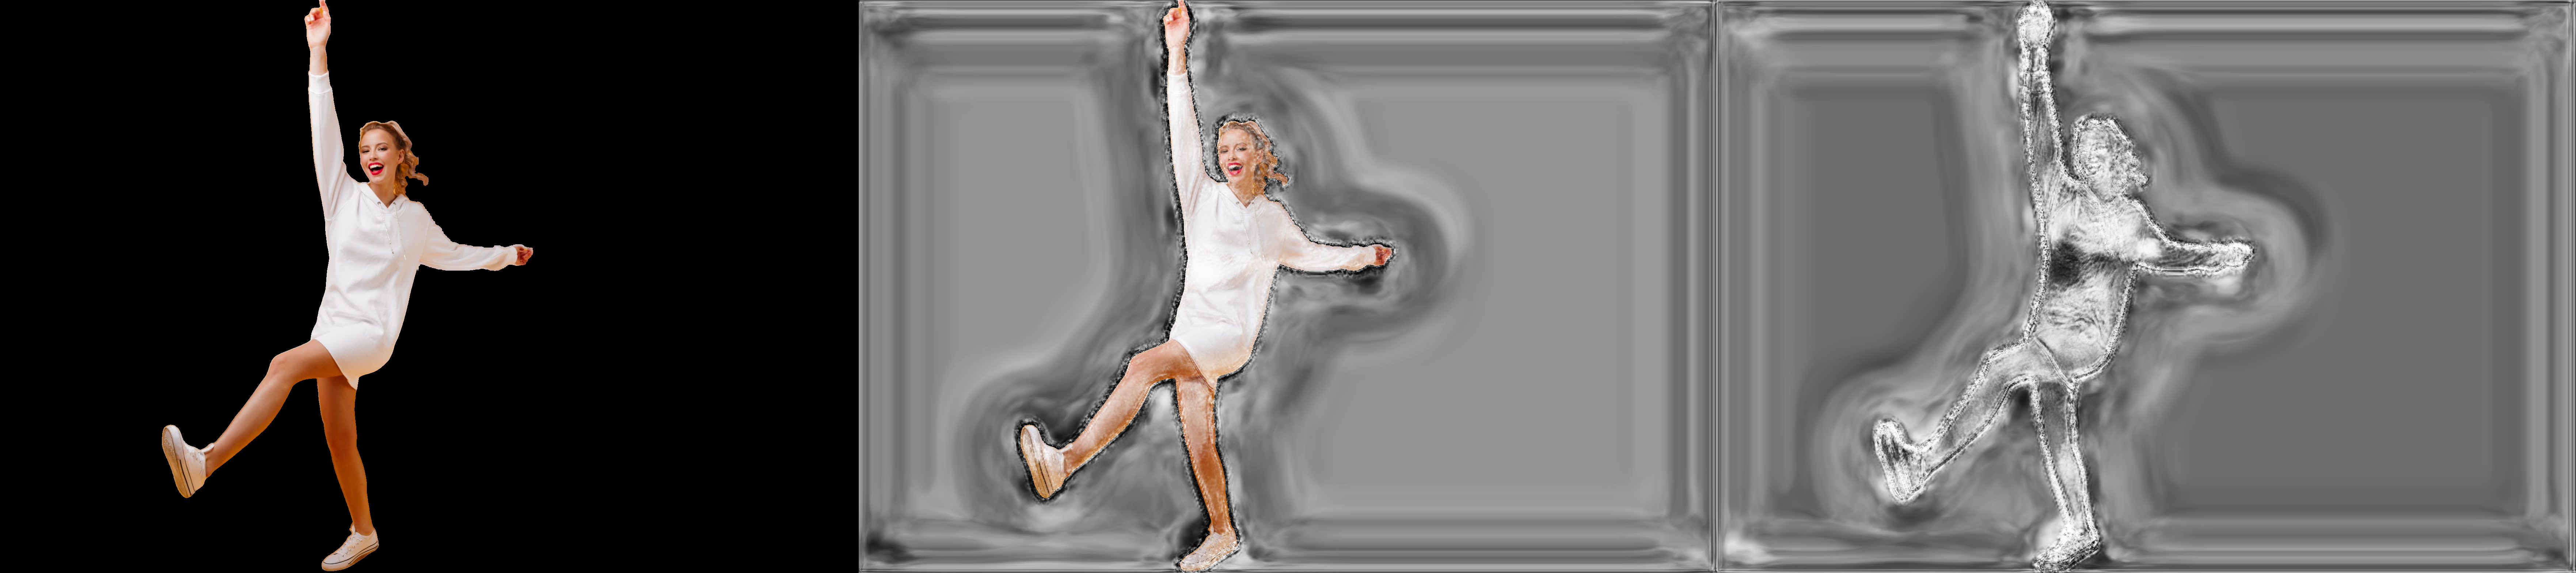

In [15]:
test.show(1)

Loaded checkpoint from checkpoints/checkpoint_45.pth.


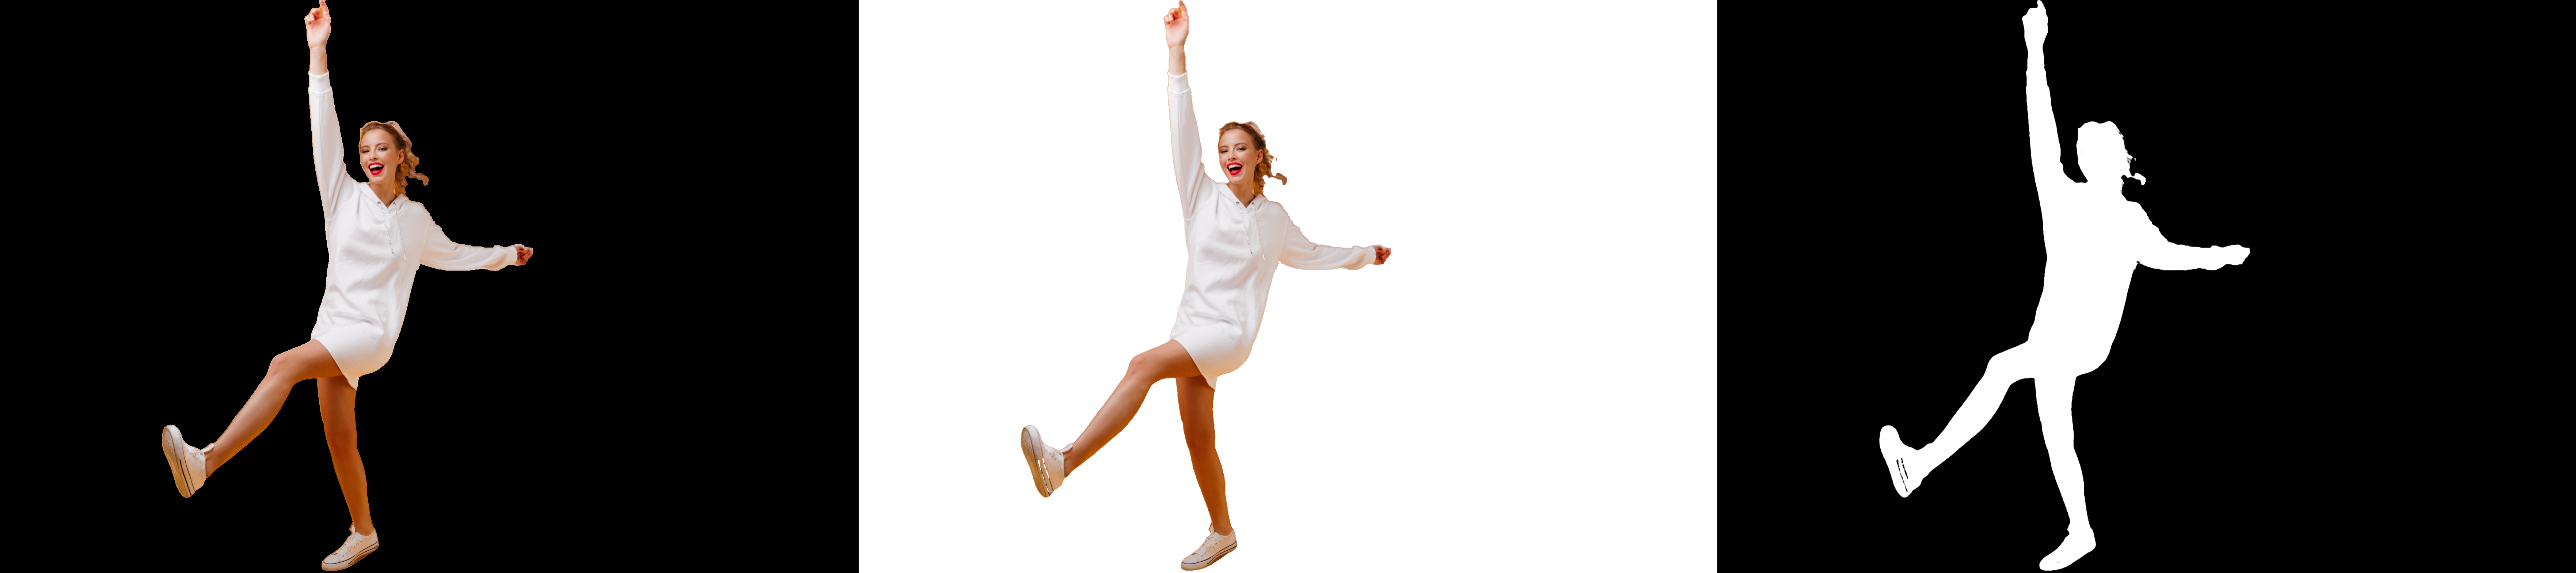

In [16]:
loser = NetTrainer(MODNet(), ckpt_path="checkpoints/checkpoint_45.pth")
los = ModNetImageGenerator(files,loser.get_model())
los.show(1)

Loaded checkpoint from checkpoints/checkpoint_10.pth.


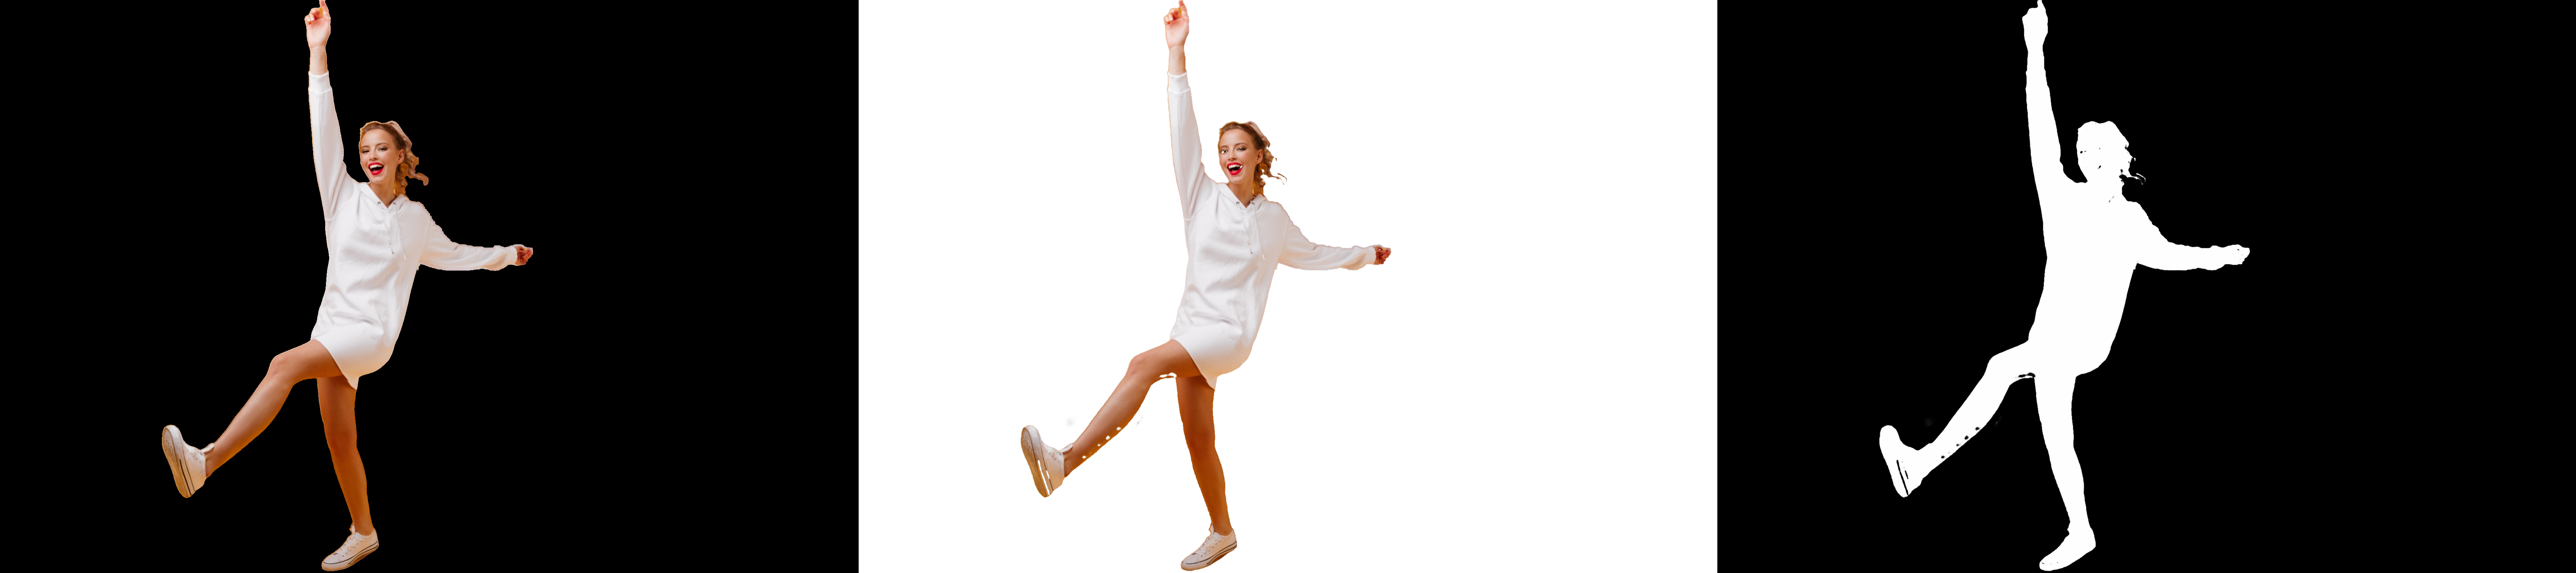

In [17]:
loser = NetTrainer(MODNet(), ckpt_path="checkpoints/checkpoint_10.pth")
los = ModNetImageGenerator(files,loser.get_model())
los.show(1)

In [18]:
loser = NetTrainer(MODNet(), ckpt_path="stop1epoch.pth")
los = ModNetImageGenerator(files,loser.get_model())
los.show(1)

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.backbone.model.features.0.0.weight", "module.backbone.model.features.0.1.weight", "module.backbone.model.features.0.1.bias", "module.backbone.model.features.0.1.running_mean", "module.backbone.model.features.0.1.running_var", "module.backbone.model.features.1.conv.0.weight", "module.backbone.model.features.1.conv.1.weight", "module.backbone.model.features.1.conv.1.bias", "module.backbone.model.features.1.conv.1.running_mean", "module.backbone.model.features.1.conv.1.running_var", "module.backbone.model.features.1.conv.3.weight", "module.backbone.model.features.1.conv.4.weight", "module.backbone.model.features.1.conv.4.bias", "module.backbone.model.features.1.conv.4.running_mean", "module.backbone.model.features.1.conv.4.running_var", "module.backbone.model.features.2.conv.0.weight", "module.backbone.model.features.2.conv.1.weight", "module.backbone.model.features.2.conv.1.bias", "module.backbone.model.features.2.conv.1.running_mean", "module.backbone.model.features.2.conv.1.running_var", "module.backbone.model.features.2.conv.3.weight", "module.backbone.model.features.2.conv.4.weight", "module.backbone.model.features.2.conv.4.bias", "module.backbone.model.features.2.conv.4.running_mean", "module.backbone.model.features.2.conv.4.running_var", "module.backbone.model.features.2.conv.6.weight", "module.backbone.model.features.2.conv.7.weight", "module.backbone.model.features.2.conv.7.bias", "module.backbone.model.features.2.conv.7.running_mean", "module.backbone.model.features.2.conv.7.running_var", "module.backbone.model.features.3.conv.0.weight", "module.backbone.model.features.3.conv.1.weight", "module.backbone.model.features.3.conv.1.bias", "module.backbone.model.features.3.conv.1.running_mean", "module.backbone.model.features.3.conv.1.running_var", "module.backbone.model.features.3.conv.3.weight", "module.backbone.model.features.3.conv.4.weight", "module.backbone.model.features.3.conv.4.bias", "module.backbone.model.features.3.conv.4.running_mean", "module.backbone.model.features.3.conv.4.running_var", "module.backbone.model.features.3.conv.6.weight", "module.backbone.model.features.3.conv.7.weight", "module.backbone.model.features.3.conv.7.bias", "module.backbone.model.features.3.conv.7.running_mean", "module.backbone.model.features.3.conv.7.running_var", "module.backbone.model.features.4.conv.0.weight", "module.backbone.model.features.4.conv.1.weight", "module.backbone.model.features.4.conv.1.bias", "module.backbone.model.features.4.conv.1.running_mean", "module.backbone.model.features.4.conv.1.running_var", "module.backbone.model.features.4.conv.3.weight", "module.backbone.model.features.4.conv.4.weight", "module.backbone.model.features.4.conv.4.bias", "module.backbone.model.features.4.conv.4.running_mean", "module.backbone.model.features.4.conv.4.running_var", "module.backbone.model.features.4.conv.6.weight", "module.backbone.model.features.4.conv.7.weight", "module.backbone.model.features.4.conv.7.bias", "module.backbone.model.features.4.conv.7.running_mean", "module.backbone.model.features.4.conv.7.running_var", "module.backbone.model.features.5.conv.0.weight", "module.backbone.model.features.5.conv.1.weight", "module.backbone.model.features.5.conv.1.bias", "module.backbone.model.features.5.conv.1.running_mean", "module.backbone.model.features.5.conv.1.running_var", "module.backbone.model.features.5.conv.3.weight", "module.backbone.model.features.5.conv.4.weight", "module.backbone.model.features.5.conv.4.bias", "module.backbone.model.features.5.conv.4.running_mean", "module.backbone.model.features.5.conv.4.running_var", "module.backbone.model.features.5.conv.6.weight", "module.backbone.model.features.5.conv.7.weight", "module.backbone.model.features.5.conv.7.bias", "module.backbone.model.features.5.conv.7.running_mean", "module.backbone.model.features.5.conv.7.running_var", "module.backbone.model.features.6.conv.0.weight", "module.backbone.model.features.6.conv.1.weight", "module.backbone.model.features.6.conv.1.bias", "module.backbone.model.features.6.conv.1.running_mean", "module.backbone.model.features.6.conv.1.running_var", "module.backbone.model.features.6.conv.3.weight", "module.backbone.model.features.6.conv.4.weight", "module.backbone.model.features.6.conv.4.bias", "module.backbone.model.features.6.conv.4.running_mean", "module.backbone.model.features.6.conv.4.running_var", "module.backbone.model.features.6.conv.6.weight", "module.backbone.model.features.6.conv.7.weight", "module.backbone.model.features.6.conv.7.bias", "module.backbone.model.features.6.conv.7.running_mean", "module.backbone.model.features.6.conv.7.running_var", "module.backbone.model.features.7.conv.0.weight", "module.backbone.model.features.7.conv.1.weight", "module.backbone.model.features.7.conv.1.bias", "module.backbone.model.features.7.conv.1.running_mean", "module.backbone.model.features.7.conv.1.running_var", "module.backbone.model.features.7.conv.3.weight", "module.backbone.model.features.7.conv.4.weight", "module.backbone.model.features.7.conv.4.bias", "module.backbone.model.features.7.conv.4.running_mean", "module.backbone.model.features.7.conv.4.running_var", "module.backbone.model.features.7.conv.6.weight", "module.backbone.model.features.7.conv.7.weight", "module.backbone.model.features.7.conv.7.bias", "module.backbone.model.features.7.conv.7.running_mean", "module.backbone.model.features.7.conv.7.running_var", "module.backbone.model.features.8.conv.0.weight", "module.backbone.model.features.8.conv.1.weight", "module.backbone.model.features.8.conv.1.bias", "module.backbone.model.features.8.conv.1.running_mean", "module.backbone.model.features.8.conv.1.running_var", "module.backbone.model.features.8.conv.3.weight", "module.backbone.model.features.8.conv.4.weight", "module.backbone.model.features.8.conv.4.bias", "module.backbone.model.features.8.conv.4.running_mean", "module.backbone.model.features.8.conv.4.running_var", "module.backbone.model.features.8.conv.6.weight", "module.backbone.model.features.8.conv.7.weight", "module.backbone.model.features.8.conv.7.bias", "module.backbone.model.features.8.conv.7.running_mean", "module.backbone.model.features.8.conv.7.running_var", "module.backbone.model.features.9.conv.0.weight", "module.backbone.model.features.9.conv.1.weight", "module.backbone.model.features.9.conv.1.bias", "module.backbone.model.features.9.conv.1.running_mean", "module.backbone.model.features.9.conv.1.running_var", "module.backbone.model.features.9.conv.3.weight", "module.backbone.model.features.9.conv.4.weight", "module.backbone.model.features.9.conv.4.bias", "module.backbone.model.features.9.conv.4.running_mean", "module.backbone.model.features.9.conv.4.running_var", "module.backbone.model.features.9.conv.6.weight", "module.backbone.model.features.9.conv.7.weight", "module.backbone.model.features.9.conv.7.bias", "module.backbone.model.features.9.conv.7.running_mean", "module.backbone.model.features.9.conv.7.running_var", "module.backbone.model.features.10.conv.0.weight", "module.backbone.model.features.10.conv.1.weight", "module.backbone.model.features.10.conv.1.bias", "module.backbone.model.features.10.conv.1.running_mean", "module.backbone.model.features.10.conv.1.running_var", "module.backbone.model.features.10.conv.3.weight", "module.backbone.model.features.10.conv.4.weight", "module.backbone.model.features.10.conv.4.bias", "module.backbone.model.features.10.conv.4.running_mean", "module.backbone.model.features.10.conv.4.running_var", "module.backbone.model.features.10.conv.6.weight", "module.backbone.model.features.10.conv.7.weight", "module.backbone.model.features.10.conv.7.bias", "module.backbone.model.features.10.conv.7.running_mean", "module.backbone.model.features.10.conv.7.running_var", "module.backbone.model.features.11.conv.0.weight", "module.backbone.model.features.11.conv.1.weight", "module.backbone.model.features.11.conv.1.bias", "module.backbone.model.features.11.conv.1.running_mean", "module.backbone.model.features.11.conv.1.running_var", "module.backbone.model.features.11.conv.3.weight", "module.backbone.model.features.11.conv.4.weight", "module.backbone.model.features.11.conv.4.bias", "module.backbone.model.features.11.conv.4.running_mean", "module.backbone.model.features.11.conv.4.running_var", "module.backbone.model.features.11.conv.6.weight", "module.backbone.model.features.11.conv.7.weight", "module.backbone.model.features.11.conv.7.bias", "module.backbone.model.features.11.conv.7.running_mean", "module.backbone.model.features.11.conv.7.running_var", "module.backbone.model.features.12.conv.0.weight", "module.backbone.model.features.12.conv.1.weight", "module.backbone.model.features.12.conv.1.bias", "module.backbone.model.features.12.conv.1.running_mean", "module.backbone.model.features.12.conv.1.running_var", "module.backbone.model.features.12.conv.3.weight", "module.backbone.model.features.12.conv.4.weight", "module.backbone.model.features.12.conv.4.bias", "module.backbone.model.features.12.conv.4.running_mean", "module.backbone.model.features.12.conv.4.running_var", "module.backbone.model.features.12.conv.6.weight", "module.backbone.model.features.12.conv.7.weight", "module.backbone.model.features.12.conv.7.bias", "module.backbone.model.features.12.conv.7.running_mean", "module.backbone.model.features.12.conv.7.running_var", "module.backbone.model.features.13.conv.0.weight", "module.backbone.model.features.13.conv.1.weight", "module.backbone.model.features.13.conv.1.bias", "module.backbone.model.features.13.conv.1.running_mean", "module.backbone.model.features.13.conv.1.running_var", "module.backbone.model.features.13.conv.3.weight", "module.backbone.model.features.13.conv.4.weight", "module.backbone.model.features.13.conv.4.bias", "module.backbone.model.features.13.conv.4.running_mean", "module.backbone.model.features.13.conv.4.running_var", "module.backbone.model.features.13.conv.6.weight", "module.backbone.model.features.13.conv.7.weight", "module.backbone.model.features.13.conv.7.bias", "module.backbone.model.features.13.conv.7.running_mean", "module.backbone.model.features.13.conv.7.running_var", "module.backbone.model.features.14.conv.0.weight", "module.backbone.model.features.14.conv.1.weight", "module.backbone.model.features.14.conv.1.bias", "module.backbone.model.features.14.conv.1.running_mean", "module.backbone.model.features.14.conv.1.running_var", "module.backbone.model.features.14.conv.3.weight", "module.backbone.model.features.14.conv.4.weight", "module.backbone.model.features.14.conv.4.bias", "module.backbone.model.features.14.conv.4.running_mean", "module.backbone.model.features.14.conv.4.running_var", "module.backbone.model.features.14.conv.6.weight", "module.backbone.model.features.14.conv.7.weight", "module.backbone.model.features.14.conv.7.bias", "module.backbone.model.features.14.conv.7.running_mean", "module.backbone.model.features.14.conv.7.running_var", "module.backbone.model.features.15.conv.0.weight", "module.backbone.model.features.15.conv.1.weight", "module.backbone.model.features.15.conv.1.bias", "module.backbone.model.features.15.conv.1.running_mean", "module.backbone.model.features.15.conv.1.running_var", "module.backbone.model.features.15.conv.3.weight", "module.backbone.model.features.15.conv.4.weight", "module.backbone.model.features.15.conv.4.bias", "module.backbone.model.features.15.conv.4.running_mean", "module.backbone.model.features.15.conv.4.running_var", "module.backbone.model.features.15.conv.6.weight", "module.backbone.model.features.15.conv.7.weight", "module.backbone.model.features.15.conv.7.bias", "module.backbone.model.features.15.conv.7.running_mean", "module.backbone.model.features.15.conv.7.running_var", "module.backbone.model.features.16.conv.0.weight", "module.backbone.model.features.16.conv.1.weight", "module.backbone.model.features.16.conv.1.bias", "module.backbone.model.features.16.conv.1.running_mean", "module.backbone.model.features.16.conv.1.running_var", "module.backbone.model.features.16.conv.3.weight", "module.backbone.model.features.16.conv.4.weight", "module.backbone.model.features.16.conv.4.bias", "module.backbone.model.features.16.conv.4.running_mean", "module.backbone.model.features.16.conv.4.running_var", "module.backbone.model.features.16.conv.6.weight", "module.backbone.model.features.16.conv.7.weight", "module.backbone.model.features.16.conv.7.bias", "module.backbone.model.features.16.conv.7.running_mean", "module.backbone.model.features.16.conv.7.running_var", "module.backbone.model.features.17.conv.0.weight", "module.backbone.model.features.17.conv.1.weight", "module.backbone.model.features.17.conv.1.bias", "module.backbone.model.features.17.conv.1.running_mean", "module.backbone.model.features.17.conv.1.running_var", "module.backbone.model.features.17.conv.3.weight", "module.backbone.model.features.17.conv.4.weight", "module.backbone.model.features.17.conv.4.bias", "module.backbone.model.features.17.conv.4.running_mean", "module.backbone.model.features.17.conv.4.running_var", "module.backbone.model.features.17.conv.6.weight", "module.backbone.model.features.17.conv.7.weight", "module.backbone.model.features.17.conv.7.bias", "module.backbone.model.features.17.conv.7.running_mean", "module.backbone.model.features.17.conv.7.running_var", "module.backbone.model.features.18.0.weight", "module.backbone.model.features.18.1.weight", "module.backbone.model.features.18.1.bias", "module.backbone.model.features.18.1.running_mean", "module.backbone.model.features.18.1.running_var", "module.lr_branch.backbone.model.features.0.0.weight", "module.lr_branch.backbone.model.features.0.1.weight", "module.lr_branch.backbone.model.features.0.1.bias", "module.lr_branch.backbone.model.features.0.1.running_mean", "module.lr_branch.backbone.model.features.0.1.running_var", "module.lr_branch.backbone.model.features.1.conv.0.weight", "module.lr_branch.backbone.model.features.1.conv.1.weight", "module.lr_branch.backbone.model.features.1.conv.1.bias", "module.lr_branch.backbone.model.features.1.conv.1.running_mean", "module.lr_branch.backbone.model.features.1.conv.1.running_var", "module.lr_branch.backbone.model.features.1.conv.3.weight", "module.lr_branch.backbone.model.features.1.conv.4.weight", "module.lr_branch.backbone.model.features.1.conv.4.bias", "module.lr_branch.backbone.model.features.1.conv.4.running_mean", "module.lr_branch.backbone.model.features.1.conv.4.running_var", "module.lr_branch.backbone.model.features.2.conv.0.weight", "module.lr_branch.backbone.model.features.2.conv.1.weight", "module.lr_branch.backbone.model.features.2.conv.1.bias", "module.lr_branch.backbone.model.features.2.conv.1.running_mean", "module.lr_branch.backbone.model.features.2.conv.1.running_var", "module.lr_branch.backbone.model.features.2.conv.3.weight", "module.lr_branch.backbone.model.features.2.conv.4.weight", "module.lr_branch.backbone.model.features.2.conv.4.bias", "module.lr_branch.backbone.model.features.2.conv.4.running_mean", "module.lr_branch.backbone.model.features.2.conv.4.running_var", "module.lr_branch.backbone.model.features.2.conv.6.weight", "module.lr_branch.backbone.model.features.2.conv.7.weight", "module.lr_branch.backbone.model.features.2.conv.7.bias", "module.lr_branch.backbone.model.features.2.conv.7.running_mean", "module.lr_branch.backbone.model.features.2.conv.7.running_var", "module.lr_branch.backbone.model.features.3.conv.0.weight", "module.lr_branch.backbone.model.features.3.conv.1.weight", "module.lr_branch.backbone.model.features.3.conv.1.bias", "module.lr_branch.backbone.model.features.3.conv.1.running_mean", "module.lr_branch.backbone.model.features.3.conv.1.running_var", "module.lr_branch.backbone.model.features.3.conv.3.weight", "module.lr_branch.backbone.model.features.3.conv.4.weight", "module.lr_branch.backbone.model.features.3.conv.4.bias", "module.lr_branch.backbone.model.features.3.conv.4.running_mean", "module.lr_branch.backbone.model.features.3.conv.4.running_var", "module.lr_branch.backbone.model.features.3.conv.6.weight", "module.lr_branch.backbone.model.features.3.conv.7.weight", "module.lr_branch.backbone.model.features.3.conv.7.bias", "module.lr_branch.backbone.model.features.3.conv.7.running_mean", "module.lr_branch.backbone.model.features.3.conv.7.running_var", "module.lr_branch.backbone.model.features.4.conv.0.weight", "module.lr_branch.backbone.model.features.4.conv.1.weight", "module.lr_branch.backbone.model.features.4.conv.1.bias", "module.lr_branch.backbone.model.features.4.conv.1.running_mean", "module.lr_branch.backbone.model.features.4.conv.1.running_var", "module.lr_branch.backbone.model.features.4.conv.3.weight", "module.lr_branch.backbone.model.features.4.conv.4.weight", "module.lr_branch.backbone.model.features.4.conv.4.bias", "module.lr_branch.backbone.model.features.4.conv.4.running_mean", "module.lr_branch.backbone.model.features.4.conv.4.running_var", "module.lr_branch.backbone.model.features.4.conv.6.weight", "module.lr_branch.backbone.model.features.4.conv.7.weight", "module.lr_branch.backbone.model.features.4.conv.7.bias", "module.lr_branch.backbone.model.features.4.conv.7.running_mean", "module.lr_branch.backbone.model.features.4.conv.7.running_var", "module.lr_branch.backbone.model.features.5.conv.0.weight", "module.lr_branch.backbone.model.features.5.conv.1.weight", "module.lr_branch.backbone.model.features.5.conv.1.bias", "module.lr_branch.backbone.model.features.5.conv.1.running_mean", "module.lr_branch.backbone.model.features.5.conv.1.running_var", "module.lr_branch.backbone.model.features.5.conv.3.weight", "module.lr_branch.backbone.model.features.5.conv.4.weight", "module.lr_branch.backbone.model.features.5.conv.4.bias", "module.lr_branch.backbone.model.features.5.conv.4.running_mean", "module.lr_branch.backbone.model.features.5.conv.4.running_var", "module.lr_branch.backbone.model.features.5.conv.6.weight", "module.lr_branch.backbone.model.features.5.conv.7.weight", "module.lr_branch.backbone.model.features.5.conv.7.bias", "module.lr_branch.backbone.model.features.5.conv.7.running_mean", "module.lr_branch.backbone.model.features.5.conv.7.running_var", "module.lr_branch.backbone.model.features.6.conv.0.weight", "module.lr_branch.backbone.model.features.6.conv.1.weight", "module.lr_branch.backbone.model.features.6.conv.1.bias", "module.lr_branch.backbone.model.features.6.conv.1.running_mean", "module.lr_branch.backbone.model.features.6.conv.1.running_var", "module.lr_branch.backbone.model.features.6.conv.3.weight", "module.lr_branch.backbone.model.features.6.conv.4.weight", "module.lr_branch.backbone.model.features.6.conv.4.bias", "module.lr_branch.backbone.model.features.6.conv.4.running_mean", "module.lr_branch.backbone.model.features.6.conv.4.running_var", "module.lr_branch.backbone.model.features.6.conv.6.weight", "module.lr_branch.backbone.model.features.6.conv.7.weight", "module.lr_branch.backbone.model.features.6.conv.7.bias", "module.lr_branch.backbone.model.features.6.conv.7.running_mean", "module.lr_branch.backbone.model.features.6.conv.7.running_var", "module.lr_branch.backbone.model.features.7.conv.0.weight", "module.lr_branch.backbone.model.features.7.conv.1.weight", "module.lr_branch.backbone.model.features.7.conv.1.bias", "module.lr_branch.backbone.model.features.7.conv.1.running_mean", "module.lr_branch.backbone.model.features.7.conv.1.running_var", "module.lr_branch.backbone.model.features.7.conv.3.weight", "module.lr_branch.backbone.model.features.7.conv.4.weight", "module.lr_branch.backbone.model.features.7.conv.4.bias", "module.lr_branch.backbone.model.features.7.conv.4.running_mean", "module.lr_branch.backbone.model.features.7.conv.4.running_var", "module.lr_branch.backbone.model.features.7.conv.6.weight", "module.lr_branch.backbone.model.features.7.conv.7.weight", "module.lr_branch.backbone.model.features.7.conv.7.bias", "module.lr_branch.backbone.model.features.7.conv.7.running_mean", "module.lr_branch.backbone.model.features.7.conv.7.running_var", "module.lr_branch.backbone.model.features.8.conv.0.weight", "module.lr_branch.backbone.model.features.8.conv.1.weight", "module.lr_branch.backbone.model.features.8.conv.1.bias", "module.lr_branch.backbone.model.features.8.conv.1.running_mean", "module.lr_branch.backbone.model.features.8.conv.1.running_var", "module.lr_branch.backbone.model.features.8.conv.3.weight", "module.lr_branch.backbone.model.features.8.conv.4.weight", "module.lr_branch.backbone.model.features.8.conv.4.bias", "module.lr_branch.backbone.model.features.8.conv.4.running_mean", "module.lr_branch.backbone.model.features.8.conv.4.running_var", "module.lr_branch.backbone.model.features.8.conv.6.weight", "module.lr_branch.backbone.model.features.8.conv.7.weight", "module.lr_branch.backbone.model.features.8.conv.7.bias", "module.lr_branch.backbone.model.features.8.conv.7.running_mean", "module.lr_branch.backbone.model.features.8.conv.7.running_var", "module.lr_branch.backbone.model.features.9.conv.0.weight", "module.lr_branch.backbone.model.features.9.conv.1.weight", "module.lr_branch.backbone.model.features.9.conv.1.bias", "module.lr_branch.backbone.model.features.9.conv.1.running_mean", "module.lr_branch.backbone.model.features.9.conv.1.running_var", "module.lr_branch.backbone.model.features.9.conv.3.weight", "module.lr_branch.backbone.model.features.9.conv.4.weight", "module.lr_branch.backbone.model.features.9.conv.4.bias", "module.lr_branch.backbone.model.features.9.conv.4.running_mean", "module.lr_branch.backbone.model.features.9.conv.4.running_var", "module.lr_branch.backbone.model.features.9.conv.6.weight", "module.lr_branch.backbone.model.features.9.conv.7.weight", "module.lr_branch.backbone.model.features.9.conv.7.bias", "module.lr_branch.backbone.model.features.9.conv.7.running_mean", "module.lr_branch.backbone.model.features.9.conv.7.running_var", "module.lr_branch.backbone.model.features.10.conv.0.weight", "module.lr_branch.backbone.model.features.10.conv.1.weight", "module.lr_branch.backbone.model.features.10.conv.1.bias", "module.lr_branch.backbone.model.features.10.conv.1.running_mean", "module.lr_branch.backbone.model.features.10.conv.1.running_var", "module.lr_branch.backbone.model.features.10.conv.3.weight", "module.lr_branch.backbone.model.features.10.conv.4.weight", "module.lr_branch.backbone.model.features.10.conv.4.bias", "module.lr_branch.backbone.model.features.10.conv.4.running_mean", "module.lr_branch.backbone.model.features.10.conv.4.running_var", "module.lr_branch.backbone.model.features.10.conv.6.weight", "module.lr_branch.backbone.model.features.10.conv.7.weight", "module.lr_branch.backbone.model.features.10.conv.7.bias", "module.lr_branch.backbone.model.features.10.conv.7.running_mean", "module.lr_branch.backbone.model.features.10.conv.7.running_var", "module.lr_branch.backbone.model.features.11.conv.0.weight", "module.lr_branch.backbone.model.features.11.conv.1.weight", "module.lr_branch.backbone.model.features.11.conv.1.bias", "module.lr_branch.backbone.model.features.11.conv.1.running_mean", "module.lr_branch.backbone.model.features.11.conv.1.running_var", "module.lr_branch.backbone.model.features.11.conv.3.weight", "module.lr_branch.backbone.model.features.11.conv.4.weight", "module.lr_branch.backbone.model.features.11.conv.4.bias", "module.lr_branch.backbone.model.features.11.conv.4.running_mean", "module.lr_branch.backbone.model.features.11.conv.4.running_var", "module.lr_branch.backbone.model.features.11.conv.6.weight", "module.lr_branch.backbone.model.features.11.conv.7.weight", "module.lr_branch.backbone.model.features.11.conv.7.bias", "module.lr_branch.backbone.model.features.11.conv.7.running_mean", "module.lr_branch.backbone.model.features.11.conv.7.running_var", "module.lr_branch.backbone.model.features.12.conv.0.weight", "module.lr_branch.backbone.model.features.12.conv.1.weight", "module.lr_branch.backbone.model.features.12.conv.1.bias", "module.lr_branch.backbone.model.features.12.conv.1.running_mean", "module.lr_branch.backbone.model.features.12.conv.1.running_var", "module.lr_branch.backbone.model.features.12.conv.3.weight", "module.lr_branch.backbone.model.features.12.conv.4.weight", "module.lr_branch.backbone.model.features.12.conv.4.bias", "module.lr_branch.backbone.model.features.12.conv.4.running_mean", "module.lr_branch.backbone.model.features.12.conv.4.running_var", "module.lr_branch.backbone.model.features.12.conv.6.weight", "module.lr_branch.backbone.model.features.12.conv.7.weight", "module.lr_branch.backbone.model.features.12.conv.7.bias", "module.lr_branch.backbone.model.features.12.conv.7.running_mean", "module.lr_branch.backbone.model.features.12.conv.7.running_var", "module.lr_branch.backbone.model.features.13.conv.0.weight", "module.lr_branch.backbone.model.features.13.conv.1.weight", "module.lr_branch.backbone.model.features.13.conv.1.bias", "module.lr_branch.backbone.model.features.13.conv.1.running_mean", "module.lr_branch.backbone.model.features.13.conv.1.running_var", "module.lr_branch.backbone.model.features.13.conv.3.weight", "module.lr_branch.backbone.model.features.13.conv.4.weight", "module.lr_branch.backbone.model.features.13.conv.4.bias", "module.lr_branch.backbone.model.features.13.conv.4.running_mean", "module.lr_branch.backbone.model.features.13.conv.4.running_var", "module.lr_branch.backbone.model.features.13.conv.6.weight", "module.lr_branch.backbone.model.features.13.conv.7.weight", "module.lr_branch.backbone.model.features.13.conv.7.bias", "module.lr_branch.backbone.model.features.13.conv.7.running_mean", "module.lr_branch.backbone.model.features.13.conv.7.running_var", "module.lr_branch.backbone.model.features.14.conv.0.weight", "module.lr_branch.backbone.model.features.14.conv.1.weight", "module.lr_branch.backbone.model.features.14.conv.1.bias", "module.lr_branch.backbone.model.features.14.conv.1.running_mean", "module.lr_branch.backbone.model.features.14.conv.1.running_var", "module.lr_branch.backbone.model.features.14.conv.3.weight", "module.lr_branch.backbone.model.features.14.conv.4.weight", "module.lr_branch.backbone.model.features.14.conv.4.bias", "module.lr_branch.backbone.model.features.14.conv.4.running_mean", "module.lr_branch.backbone.model.features.14.conv.4.running_var", "module.lr_branch.backbone.model.features.14.conv.6.weight", "module.lr_branch.backbone.model.features.14.conv.7.weight", "module.lr_branch.backbone.model.features.14.conv.7.bias", "module.lr_branch.backbone.model.features.14.conv.7.running_mean", "module.lr_branch.backbone.model.features.14.conv.7.running_var", "module.lr_branch.backbone.model.features.15.conv.0.weight", "module.lr_branch.backbone.model.features.15.conv.1.weight", "module.lr_branch.backbone.model.features.15.conv.1.bias", "module.lr_branch.backbone.model.features.15.conv.1.running_mean", "module.lr_branch.backbone.model.features.15.conv.1.running_var", "module.lr_branch.backbone.model.features.15.conv.3.weight", "module.lr_branch.backbone.model.features.15.conv.4.weight", "module.lr_branch.backbone.model.features.15.conv.4.bias", "module.lr_branch.backbone.model.features.15.conv.4.running_mean", "module.lr_branch.backbone.model.features.15.conv.4.running_var", "module.lr_branch.backbone.model.features.15.conv.6.weight", "module.lr_branch.backbone.model.features.15.conv.7.weight", "module.lr_branch.backbone.model.features.15.conv.7.bias", "module.lr_branch.backbone.model.features.15.conv.7.running_mean", "module.lr_branch.backbone.model.features.15.conv.7.running_var", "module.lr_branch.backbone.model.features.16.conv.0.weight", "module.lr_branch.backbone.model.features.16.conv.1.weight", "module.lr_branch.backbone.model.features.16.conv.1.bias", "module.lr_branch.backbone.model.features.16.conv.1.running_mean", "module.lr_branch.backbone.model.features.16.conv.1.running_var", "module.lr_branch.backbone.model.features.16.conv.3.weight", "module.lr_branch.backbone.model.features.16.conv.4.weight", "module.lr_branch.backbone.model.features.16.conv.4.bias", "module.lr_branch.backbone.model.features.16.conv.4.running_mean", "module.lr_branch.backbone.model.features.16.conv.4.running_var", "module.lr_branch.backbone.model.features.16.conv.6.weight", "module.lr_branch.backbone.model.features.16.conv.7.weight", "module.lr_branch.backbone.model.features.16.conv.7.bias", "module.lr_branch.backbone.model.features.16.conv.7.running_mean", "module.lr_branch.backbone.model.features.16.conv.7.running_var", "module.lr_branch.backbone.model.features.17.conv.0.weight", "module.lr_branch.backbone.model.features.17.conv.1.weight", "module.lr_branch.backbone.model.features.17.conv.1.bias", "module.lr_branch.backbone.model.features.17.conv.1.running_mean", "module.lr_branch.backbone.model.features.17.conv.1.running_var", "module.lr_branch.backbone.model.features.17.conv.3.weight", "module.lr_branch.backbone.model.features.17.conv.4.weight", "module.lr_branch.backbone.model.features.17.conv.4.bias", "module.lr_branch.backbone.model.features.17.conv.4.running_mean", "module.lr_branch.backbone.model.features.17.conv.4.running_var", "module.lr_branch.backbone.model.features.17.conv.6.weight", "module.lr_branch.backbone.model.features.17.conv.7.weight", "module.lr_branch.backbone.model.features.17.conv.7.bias", "module.lr_branch.backbone.model.features.17.conv.7.running_mean", "module.lr_branch.backbone.model.features.17.conv.7.running_var", "module.lr_branch.backbone.model.features.18.0.weight", "module.lr_branch.backbone.model.features.18.1.weight", "module.lr_branch.backbone.model.features.18.1.bias", "module.lr_branch.backbone.model.features.18.1.running_mean", "module.lr_branch.backbone.model.features.18.1.running_var", "module.lr_branch.se_block.fc.0.weight", "module.lr_branch.se_block.fc.2.weight", "module.lr_branch.conv_lr16x.layers.0.weight", "module.lr_branch.conv_lr16x.layers.0.bias", "module.lr_branch.conv_lr16x.layers.1.bnorm.weight", "module.lr_branch.conv_lr16x.layers.1.bnorm.bias", "module.lr_branch.conv_lr16x.layers.1.bnorm.running_mean", "module.lr_branch.conv_lr16x.layers.1.bnorm.running_var", "module.lr_branch.conv_lr8x.layers.0.weight", "module.lr_branch.conv_lr8x.layers.0.bias", "module.lr_branch.conv_lr8x.layers.1.bnorm.weight", "module.lr_branch.conv_lr8x.layers.1.bnorm.bias", "module.lr_branch.conv_lr8x.layers.1.bnorm.running_mean", "module.lr_branch.conv_lr8x.layers.1.bnorm.running_var", "module.lr_branch.conv_lr.layers.0.weight", "module.lr_branch.conv_lr.layers.0.bias", "module.hr_branch.tohr_enc2x.layers.0.weight", "module.hr_branch.tohr_enc2x.layers.0.bias", "module.hr_branch.tohr_enc2x.layers.1.bnorm.weight", "module.hr_branch.tohr_enc2x.layers.1.bnorm.bias", "module.hr_branch.tohr_enc2x.layers.1.bnorm.running_mean", "module.hr_branch.tohr_enc2x.layers.1.bnorm.running_var", "module.hr_branch.conv_enc2x.layers.0.weight", "module.hr_branch.conv_enc2x.layers.0.bias", "module.hr_branch.conv_enc2x.layers.1.bnorm.weight", "module.hr_branch.conv_enc2x.layers.1.bnorm.bias", "module.hr_branch.conv_enc2x.layers.1.bnorm.running_mean", "module.hr_branch.conv_enc2x.layers.1.bnorm.running_var", "module.hr_branch.tohr_enc4x.layers.0.weight", "module.hr_branch.tohr_enc4x.layers.0.bias", "module.hr_branch.tohr_enc4x.layers.1.bnorm.weight", "module.hr_branch.tohr_enc4x.layers.1.bnorm.bias", "module.hr_branch.tohr_enc4x.layers.1.bnorm.running_mean", "module.hr_branch.tohr_enc4x.layers.1.bnorm.running_var", "module.hr_branch.conv_enc4x.layers.0.weight", "module.hr_branch.conv_enc4x.layers.0.bias", "module.hr_branch.conv_enc4x.layers.1.bnorm.weight", "module.hr_branch.conv_enc4x.layers.1.bnorm.bias", "module.hr_branch.conv_enc4x.layers.1.bnorm.running_mean", "module.hr_branch.conv_enc4x.layers.1.bnorm.running_var", "module.hr_branch.conv_hr4x.0.layers.0.weight", "module.hr_branch.conv_hr4x.0.layers.0.bias", "module.hr_branch.conv_hr4x.0.layers.1.bnorm.weight", "module.hr_branch.conv_hr4x.0.layers.1.bnorm.bias", "module.hr_branch.conv_hr4x.0.layers.1.bnorm.running_mean", "module.hr_branch.conv_hr4x.0.layers.1.bnorm.running_var", "module.hr_branch.conv_hr4x.1.layers.0.weight", "module.hr_branch.conv_hr4x.1.layers.0.bias", "module.hr_branch.conv_hr4x.1.layers.1.bnorm.weight", "module.hr_branch.conv_hr4x.1.layers.1.bnorm.bias", "module.hr_branch.conv_hr4x.1.layers.1.bnorm.running_mean", "module.hr_branch.conv_hr4x.1.layers.1.bnorm.running_var", "module.hr_branch.conv_hr4x.2.layers.0.weight", "module.hr_branch.conv_hr4x.2.layers.0.bias", "module.hr_branch.conv_hr4x.2.layers.1.bnorm.weight", "module.hr_branch.conv_hr4x.2.layers.1.bnorm.bias", "module.hr_branch.conv_hr4x.2.layers.1.bnorm.running_mean", "module.hr_branch.conv_hr4x.2.layers.1.bnorm.running_var", "module.hr_branch.conv_hr2x.0.layers.0.weight", "module.hr_branch.conv_hr2x.0.layers.0.bias", "module.hr_branch.conv_hr2x.0.layers.1.bnorm.weight", "module.hr_branch.conv_hr2x.0.layers.1.bnorm.bias", "module.hr_branch.conv_hr2x.0.layers.1.bnorm.running_mean", "module.hr_branch.conv_hr2x.0.layers.1.bnorm.running_var", "module.hr_branch.conv_hr2x.1.layers.0.weight", "module.hr_branch.conv_hr2x.1.layers.0.bias", "module.hr_branch.conv_hr2x.1.layers.1.bnorm.weight", "module.hr_branch.conv_hr2x.1.layers.1.bnorm.bias", "module.hr_branch.conv_hr2x.1.layers.1.bnorm.running_mean", "module.hr_branch.conv_hr2x.1.layers.1.bnorm.running_var", "module.hr_branch.conv_hr2x.2.layers.0.weight", "module.hr_branch.conv_hr2x.2.layers.0.bias", "module.hr_branch.conv_hr2x.2.layers.1.bnorm.weight", "module.hr_branch.conv_hr2x.2.layers.1.bnorm.bias", "module.hr_branch.conv_hr2x.2.layers.1.bnorm.running_mean", "module.hr_branch.conv_hr2x.2.layers.1.bnorm.running_var", "module.hr_branch.conv_hr2x.3.layers.0.weight", "module.hr_branch.conv_hr2x.3.layers.0.bias", "module.hr_branch.conv_hr2x.3.layers.1.bnorm.weight", "module.hr_branch.conv_hr2x.3.layers.1.bnorm.bias", "module.hr_branch.conv_hr2x.3.layers.1.bnorm.running_mean", "module.hr_branch.conv_hr2x.3.layers.1.bnorm.running_var", "module.hr_branch.conv_hr.0.layers.0.weight", "module.hr_branch.conv_hr.0.layers.0.bias", "module.hr_branch.conv_hr.0.layers.1.bnorm.weight", "module.hr_branch.conv_hr.0.layers.1.bnorm.bias", "module.hr_branch.conv_hr.0.layers.1.bnorm.running_mean", "module.hr_branch.conv_hr.0.layers.1.bnorm.running_var", "module.hr_branch.conv_hr.1.layers.0.weight", "module.hr_branch.conv_hr.1.layers.0.bias", "module.f_branch.conv_lr4x.layers.0.weight", "module.f_branch.conv_lr4x.layers.0.bias", "module.f_branch.conv_lr4x.layers.1.bnorm.weight", "module.f_branch.conv_lr4x.layers.1.bnorm.bias", "module.f_branch.conv_lr4x.layers.1.bnorm.running_mean", "module.f_branch.conv_lr4x.layers.1.bnorm.running_var", "module.f_branch.conv_f2x.layers.0.weight", "module.f_branch.conv_f2x.layers.0.bias", "module.f_branch.conv_f2x.layers.1.bnorm.weight", "module.f_branch.conv_f2x.layers.1.bnorm.bias", "module.f_branch.conv_f2x.layers.1.bnorm.running_mean", "module.f_branch.conv_f2x.layers.1.bnorm.running_var", "module.f_branch.conv_f.0.layers.0.weight", "module.f_branch.conv_f.0.layers.0.bias", "module.f_branch.conv_f.0.layers.1.bnorm.weight", "module.f_branch.conv_f.0.layers.1.bnorm.bias", "module.f_branch.conv_f.0.layers.1.bnorm.running_mean", "module.f_branch.conv_f.0.layers.1.bnorm.running_var", "module.f_branch.conv_f.1.layers.0.weight", "module.f_branch.conv_f.1.layers.0.bias". 
	Unexpected key(s) in state_dict: "backbone.model.features.0.0.weight", "backbone.model.features.0.1.weight", "backbone.model.features.0.1.bias", "backbone.model.features.0.1.running_mean", "backbone.model.features.0.1.running_var", "backbone.model.features.0.1.num_batches_tracked", "backbone.model.features.1.conv.0.weight", "backbone.model.features.1.conv.1.weight", "backbone.model.features.1.conv.1.bias", "backbone.model.features.1.conv.1.running_mean", "backbone.model.features.1.conv.1.running_var", "backbone.model.features.1.conv.1.num_batches_tracked", "backbone.model.features.1.conv.3.weight", "backbone.model.features.1.conv.4.weight", "backbone.model.features.1.conv.4.bias", "backbone.model.features.1.conv.4.running_mean", "backbone.model.features.1.conv.4.running_var", "backbone.model.features.1.conv.4.num_batches_tracked", "backbone.model.features.2.conv.0.weight", "backbone.model.features.2.conv.1.weight", "backbone.model.features.2.conv.1.bias", "backbone.model.features.2.conv.1.running_mean", "backbone.model.features.2.conv.1.running_var", "backbone.model.features.2.conv.1.num_batches_tracked", "backbone.model.features.2.conv.3.weight", "backbone.model.features.2.conv.4.weight", "backbone.model.features.2.conv.4.bias", "backbone.model.features.2.conv.4.running_mean", "backbone.model.features.2.conv.4.running_var", "backbone.model.features.2.conv.4.num_batches_tracked", "backbone.model.features.2.conv.6.weight", "backbone.model.features.2.conv.7.weight", "backbone.model.features.2.conv.7.bias", "backbone.model.features.2.conv.7.running_mean", "backbone.model.features.2.conv.7.running_var", "backbone.model.features.2.conv.7.num_batches_tracked", "backbone.model.features.3.conv.0.weight", "backbone.model.features.3.conv.1.weight", "backbone.model.features.3.conv.1.bias", "backbone.model.features.3.conv.1.running_mean", "backbone.model.features.3.conv.1.running_var", "backbone.model.features.3.conv.1.num_batches_tracked", "backbone.model.features.3.conv.3.weight", "backbone.model.features.3.conv.4.weight", "backbone.model.features.3.conv.4.bias", "backbone.model.features.3.conv.4.running_mean", "backbone.model.features.3.conv.4.running_var", "backbone.model.features.3.conv.4.num_batches_tracked", "backbone.model.features.3.conv.6.weight", "backbone.model.features.3.conv.7.weight", "backbone.model.features.3.conv.7.bias", "backbone.model.features.3.conv.7.running_mean", "backbone.model.features.3.conv.7.running_var", "backbone.model.features.3.conv.7.num_batches_tracked", "backbone.model.features.4.conv.0.weight", "backbone.model.features.4.conv.1.weight", "backbone.model.features.4.conv.1.bias", "backbone.model.features.4.conv.1.running_mean", "backbone.model.features.4.conv.1.running_var", "backbone.model.features.4.conv.1.num_batches_tracked", "backbone.model.features.4.conv.3.weight", "backbone.model.features.4.conv.4.weight", "backbone.model.features.4.conv.4.bias", "backbone.model.features.4.conv.4.running_mean", "backbone.model.features.4.conv.4.running_var", "backbone.model.features.4.conv.4.num_batches_tracked", "backbone.model.features.4.conv.6.weight", "backbone.model.features.4.conv.7.weight", "backbone.model.features.4.conv.7.bias", "backbone.model.features.4.conv.7.running_mean", "backbone.model.features.4.conv.7.running_var", "backbone.model.features.4.conv.7.num_batches_tracked", "backbone.model.features.5.conv.0.weight", "backbone.model.features.5.conv.1.weight", "backbone.model.features.5.conv.1.bias", "backbone.model.features.5.conv.1.running_mean", "backbone.model.features.5.conv.1.running_var", "backbone.model.features.5.conv.1.num_batches_tracked", "backbone.model.features.5.conv.3.weight", "backbone.model.features.5.conv.4.weight", "backbone.model.features.5.conv.4.bias", "backbone.model.features.5.conv.4.running_mean", "backbone.model.features.5.conv.4.running_var", "backbone.model.features.5.conv.4.num_batches_tracked", "backbone.model.features.5.conv.6.weight", "backbone.model.features.5.conv.7.weight", "backbone.model.features.5.conv.7.bias", "backbone.model.features.5.conv.7.running_mean", "backbone.model.features.5.conv.7.running_var", "backbone.model.features.5.conv.7.num_batches_tracked", "backbone.model.features.6.conv.0.weight", "backbone.model.features.6.conv.1.weight", "backbone.model.features.6.conv.1.bias", "backbone.model.features.6.conv.1.running_mean", "backbone.model.features.6.conv.1.running_var", "backbone.model.features.6.conv.1.num_batches_tracked", "backbone.model.features.6.conv.3.weight", "backbone.model.features.6.conv.4.weight", "backbone.model.features.6.conv.4.bias", "backbone.model.features.6.conv.4.running_mean", "backbone.model.features.6.conv.4.running_var", "backbone.model.features.6.conv.4.num_batches_tracked", "backbone.model.features.6.conv.6.weight", "backbone.model.features.6.conv.7.weight", "backbone.model.features.6.conv.7.bias", "backbone.model.features.6.conv.7.running_mean", "backbone.model.features.6.conv.7.running_var", "backbone.model.features.6.conv.7.num_batches_tracked", "backbone.model.features.7.conv.0.weight", "backbone.model.features.7.conv.1.weight", "backbone.model.features.7.conv.1.bias", "backbone.model.features.7.conv.1.running_mean", "backbone.model.features.7.conv.1.running_var", "backbone.model.features.7.conv.1.num_batches_tracked", "backbone.model.features.7.conv.3.weight", "backbone.model.features.7.conv.4.weight", "backbone.model.features.7.conv.4.bias", "backbone.model.features.7.conv.4.running_mean", "backbone.model.features.7.conv.4.running_var", "backbone.model.features.7.conv.4.num_batches_tracked", "backbone.model.features.7.conv.6.weight", "backbone.model.features.7.conv.7.weight", "backbone.model.features.7.conv.7.bias", "backbone.model.features.7.conv.7.running_mean", "backbone.model.features.7.conv.7.running_var", "backbone.model.features.7.conv.7.num_batches_tracked", "backbone.model.features.8.conv.0.weight", "backbone.model.features.8.conv.1.weight", "backbone.model.features.8.conv.1.bias", "backbone.model.features.8.conv.1.running_mean", "backbone.model.features.8.conv.1.running_var", "backbone.model.features.8.conv.1.num_batches_tracked", "backbone.model.features.8.conv.3.weight", "backbone.model.features.8.conv.4.weight", "backbone.model.features.8.conv.4.bias", "backbone.model.features.8.conv.4.running_mean", "backbone.model.features.8.conv.4.running_var", "backbone.model.features.8.conv.4.num_batches_tracked", "backbone.model.features.8.conv.6.weight", "backbone.model.features.8.conv.7.weight", "backbone.model.features.8.conv.7.bias", "backbone.model.features.8.conv.7.running_mean", "backbone.model.features.8.conv.7.running_var", "backbone.model.features.8.conv.7.num_batches_tracked", "backbone.model.features.9.conv.0.weight", "backbone.model.features.9.conv.1.weight", "backbone.model.features.9.conv.1.bias", "backbone.model.features.9.conv.1.running_mean", "backbone.model.features.9.conv.1.running_var", "backbone.model.features.9.conv.1.num_batches_tracked", "backbone.model.features.9.conv.3.weight", "backbone.model.features.9.conv.4.weight", "backbone.model.features.9.conv.4.bias", "backbone.model.features.9.conv.4.running_mean", "backbone.model.features.9.conv.4.running_var", "backbone.model.features.9.conv.4.num_batches_tracked", "backbone.model.features.9.conv.6.weight", "backbone.model.features.9.conv.7.weight", "backbone.model.features.9.conv.7.bias", "backbone.model.features.9.conv.7.running_mean", "backbone.model.features.9.conv.7.running_var", "backbone.model.features.9.conv.7.num_batches_tracked", "backbone.model.features.10.conv.0.weight", "backbone.model.features.10.conv.1.weight", "backbone.model.features.10.conv.1.bias", "backbone.model.features.10.conv.1.running_mean", "backbone.model.features.10.conv.1.running_var", "backbone.model.features.10.conv.1.num_batches_tracked", "backbone.model.features.10.conv.3.weight", "backbone.model.features.10.conv.4.weight", "backbone.model.features.10.conv.4.bias", "backbone.model.features.10.conv.4.running_mean", "backbone.model.features.10.conv.4.running_var", "backbone.model.features.10.conv.4.num_batches_tracked", "backbone.model.features.10.conv.6.weight", "backbone.model.features.10.conv.7.weight", "backbone.model.features.10.conv.7.bias", "backbone.model.features.10.conv.7.running_mean", "backbone.model.features.10.conv.7.running_var", "backbone.model.features.10.conv.7.num_batches_tracked", "backbone.model.features.11.conv.0.weight", "backbone.model.features.11.conv.1.weight", "backbone.model.features.11.conv.1.bias", "backbone.model.features.11.conv.1.running_mean", "backbone.model.features.11.conv.1.running_var", "backbone.model.features.11.conv.1.num_batches_tracked", "backbone.model.features.11.conv.3.weight", "backbone.model.features.11.conv.4.weight", "backbone.model.features.11.conv.4.bias", "backbone.model.features.11.conv.4.running_mean", "backbone.model.features.11.conv.4.running_var", "backbone.model.features.11.conv.4.num_batches_tracked", "backbone.model.features.11.conv.6.weight", "backbone.model.features.11.conv.7.weight", "backbone.model.features.11.conv.7.bias", "backbone.model.features.11.conv.7.running_mean", "backbone.model.features.11.conv.7.running_var", "backbone.model.features.11.conv.7.num_batches_tracked", "backbone.model.features.12.conv.0.weight", "backbone.model.features.12.conv.1.weight", "backbone.model.features.12.conv.1.bias", "backbone.model.features.12.conv.1.running_mean", "backbone.model.features.12.conv.1.running_var", "backbone.model.features.12.conv.1.num_batches_tracked", "backbone.model.features.12.conv.3.weight", "backbone.model.features.12.conv.4.weight", "backbone.model.features.12.conv.4.bias", "backbone.model.features.12.conv.4.running_mean", "backbone.model.features.12.conv.4.running_var", "backbone.model.features.12.conv.4.num_batches_tracked", "backbone.model.features.12.conv.6.weight", "backbone.model.features.12.conv.7.weight", "backbone.model.features.12.conv.7.bias", "backbone.model.features.12.conv.7.running_mean", "backbone.model.features.12.conv.7.running_var", "backbone.model.features.12.conv.7.num_batches_tracked", "backbone.model.features.13.conv.0.weight", "backbone.model.features.13.conv.1.weight", "backbone.model.features.13.conv.1.bias", "backbone.model.features.13.conv.1.running_mean", "backbone.model.features.13.conv.1.running_var", "backbone.model.features.13.conv.1.num_batches_tracked", "backbone.model.features.13.conv.3.weight", "backbone.model.features.13.conv.4.weight", "backbone.model.features.13.conv.4.bias", "backbone.model.features.13.conv.4.running_mean", "backbone.model.features.13.conv.4.running_var", "backbone.model.features.13.conv.4.num_batches_tracked", "backbone.model.features.13.conv.6.weight", "backbone.model.features.13.conv.7.weight", "backbone.model.features.13.conv.7.bias", "backbone.model.features.13.conv.7.running_mean", "backbone.model.features.13.conv.7.running_var", "backbone.model.features.13.conv.7.num_batches_tracked", "backbone.model.features.14.conv.0.weight", "backbone.model.features.14.conv.1.weight", "backbone.model.features.14.conv.1.bias", "backbone.model.features.14.conv.1.running_mean", "backbone.model.features.14.conv.1.running_var", "backbone.model.features.14.conv.1.num_batches_tracked", "backbone.model.features.14.conv.3.weight", "backbone.model.features.14.conv.4.weight", "backbone.model.features.14.conv.4.bias", "backbone.model.features.14.conv.4.running_mean", "backbone.model.features.14.conv.4.running_var", "backbone.model.features.14.conv.4.num_batches_tracked", "backbone.model.features.14.conv.6.weight", "backbone.model.features.14.conv.7.weight", "backbone.model.features.14.conv.7.bias", "backbone.model.features.14.conv.7.running_mean", "backbone.model.features.14.conv.7.running_var", "backbone.model.features.14.conv.7.num_batches_tracked", "backbone.model.features.15.conv.0.weight", "backbone.model.features.15.conv.1.weight", "backbone.model.features.15.conv.1.bias", "backbone.model.features.15.conv.1.running_mean", "backbone.model.features.15.conv.1.running_var", "backbone.model.features.15.conv.1.num_batches_tracked", "backbone.model.features.15.conv.3.weight", "backbone.model.features.15.conv.4.weight", "backbone.model.features.15.conv.4.bias", "backbone.model.features.15.conv.4.running_mean", "backbone.model.features.15.conv.4.running_var", "backbone.model.features.15.conv.4.num_batches_tracked", "backbone.model.features.15.conv.6.weight", "backbone.model.features.15.conv.7.weight", "backbone.model.features.15.conv.7.bias", "backbone.model.features.15.conv.7.running_mean", "backbone.model.features.15.conv.7.running_var", "backbone.model.features.15.conv.7.num_batches_tracked", "backbone.model.features.16.conv.0.weight", "backbone.model.features.16.conv.1.weight", "backbone.model.features.16.conv.1.bias", "backbone.model.features.16.conv.1.running_mean", "backbone.model.features.16.conv.1.running_var", "backbone.model.features.16.conv.1.num_batches_tracked", "backbone.model.features.16.conv.3.weight", "backbone.model.features.16.conv.4.weight", "backbone.model.features.16.conv.4.bias", "backbone.model.features.16.conv.4.running_mean", "backbone.model.features.16.conv.4.running_var", "backbone.model.features.16.conv.4.num_batches_tracked", "backbone.model.features.16.conv.6.weight", "backbone.model.features.16.conv.7.weight", "backbone.model.features.16.conv.7.bias", "backbone.model.features.16.conv.7.running_mean", "backbone.model.features.16.conv.7.running_var", "backbone.model.features.16.conv.7.num_batches_tracked", "backbone.model.features.17.conv.0.weight", "backbone.model.features.17.conv.1.weight", "backbone.model.features.17.conv.1.bias", "backbone.model.features.17.conv.1.running_mean", "backbone.model.features.17.conv.1.running_var", "backbone.model.features.17.conv.1.num_batches_tracked", "backbone.model.features.17.conv.3.weight", "backbone.model.features.17.conv.4.weight", "backbone.model.features.17.conv.4.bias", "backbone.model.features.17.conv.4.running_mean", "backbone.model.features.17.conv.4.running_var", "backbone.model.features.17.conv.4.num_batches_tracked", "backbone.model.features.17.conv.6.weight", "backbone.model.features.17.conv.7.weight", "backbone.model.features.17.conv.7.bias", "backbone.model.features.17.conv.7.running_mean", "backbone.model.features.17.conv.7.running_var", "backbone.model.features.17.conv.7.num_batches_tracked", "backbone.model.features.18.0.weight", "backbone.model.features.18.1.weight", "backbone.model.features.18.1.bias", "backbone.model.features.18.1.running_mean", "backbone.model.features.18.1.running_var", "backbone.model.features.18.1.num_batches_tracked", "lr_branch.backbone.model.features.0.0.weight", "lr_branch.backbone.model.features.0.1.weight", "lr_branch.backbone.model.features.0.1.bias", "lr_branch.backbone.model.features.0.1.running_mean", "lr_branch.backbone.model.features.0.1.running_var", "lr_branch.backbone.model.features.0.1.num_batches_tracked", "lr_branch.backbone.model.features.1.conv.0.weight", "lr_branch.backbone.model.features.1.conv.1.weight", "lr_branch.backbone.model.features.1.conv.1.bias", "lr_branch.backbone.model.features.1.conv.1.running_mean", "lr_branch.backbone.model.features.1.conv.1.running_var", "lr_branch.backbone.model.features.1.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.1.conv.3.weight", "lr_branch.backbone.model.features.1.conv.4.weight", "lr_branch.backbone.model.features.1.conv.4.bias", "lr_branch.backbone.model.features.1.conv.4.running_mean", "lr_branch.backbone.model.features.1.conv.4.running_var", "lr_branch.backbone.model.features.1.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.2.conv.0.weight", "lr_branch.backbone.model.features.2.conv.1.weight", "lr_branch.backbone.model.features.2.conv.1.bias", "lr_branch.backbone.model.features.2.conv.1.running_mean", "lr_branch.backbone.model.features.2.conv.1.running_var", "lr_branch.backbone.model.features.2.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.2.conv.3.weight", "lr_branch.backbone.model.features.2.conv.4.weight", "lr_branch.backbone.model.features.2.conv.4.bias", "lr_branch.backbone.model.features.2.conv.4.running_mean", "lr_branch.backbone.model.features.2.conv.4.running_var", "lr_branch.backbone.model.features.2.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.2.conv.6.weight", "lr_branch.backbone.model.features.2.conv.7.weight", "lr_branch.backbone.model.features.2.conv.7.bias", "lr_branch.backbone.model.features.2.conv.7.running_mean", "lr_branch.backbone.model.features.2.conv.7.running_var", "lr_branch.backbone.model.features.2.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.3.conv.0.weight", "lr_branch.backbone.model.features.3.conv.1.weight", "lr_branch.backbone.model.features.3.conv.1.bias", "lr_branch.backbone.model.features.3.conv.1.running_mean", "lr_branch.backbone.model.features.3.conv.1.running_var", "lr_branch.backbone.model.features.3.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.3.conv.3.weight", "lr_branch.backbone.model.features.3.conv.4.weight", "lr_branch.backbone.model.features.3.conv.4.bias", "lr_branch.backbone.model.features.3.conv.4.running_mean", "lr_branch.backbone.model.features.3.conv.4.running_var", "lr_branch.backbone.model.features.3.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.3.conv.6.weight", "lr_branch.backbone.model.features.3.conv.7.weight", "lr_branch.backbone.model.features.3.conv.7.bias", "lr_branch.backbone.model.features.3.conv.7.running_mean", "lr_branch.backbone.model.features.3.conv.7.running_var", "lr_branch.backbone.model.features.3.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.4.conv.0.weight", "lr_branch.backbone.model.features.4.conv.1.weight", "lr_branch.backbone.model.features.4.conv.1.bias", "lr_branch.backbone.model.features.4.conv.1.running_mean", "lr_branch.backbone.model.features.4.conv.1.running_var", "lr_branch.backbone.model.features.4.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.4.conv.3.weight", "lr_branch.backbone.model.features.4.conv.4.weight", "lr_branch.backbone.model.features.4.conv.4.bias", "lr_branch.backbone.model.features.4.conv.4.running_mean", "lr_branch.backbone.model.features.4.conv.4.running_var", "lr_branch.backbone.model.features.4.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.4.conv.6.weight", "lr_branch.backbone.model.features.4.conv.7.weight", "lr_branch.backbone.model.features.4.conv.7.bias", "lr_branch.backbone.model.features.4.conv.7.running_mean", "lr_branch.backbone.model.features.4.conv.7.running_var", "lr_branch.backbone.model.features.4.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.5.conv.0.weight", "lr_branch.backbone.model.features.5.conv.1.weight", "lr_branch.backbone.model.features.5.conv.1.bias", "lr_branch.backbone.model.features.5.conv.1.running_mean", "lr_branch.backbone.model.features.5.conv.1.running_var", "lr_branch.backbone.model.features.5.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.5.conv.3.weight", "lr_branch.backbone.model.features.5.conv.4.weight", "lr_branch.backbone.model.features.5.conv.4.bias", "lr_branch.backbone.model.features.5.conv.4.running_mean", "lr_branch.backbone.model.features.5.conv.4.running_var", "lr_branch.backbone.model.features.5.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.5.conv.6.weight", "lr_branch.backbone.model.features.5.conv.7.weight", "lr_branch.backbone.model.features.5.conv.7.bias", "lr_branch.backbone.model.features.5.conv.7.running_mean", "lr_branch.backbone.model.features.5.conv.7.running_var", "lr_branch.backbone.model.features.5.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.6.conv.0.weight", "lr_branch.backbone.model.features.6.conv.1.weight", "lr_branch.backbone.model.features.6.conv.1.bias", "lr_branch.backbone.model.features.6.conv.1.running_mean", "lr_branch.backbone.model.features.6.conv.1.running_var", "lr_branch.backbone.model.features.6.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.6.conv.3.weight", "lr_branch.backbone.model.features.6.conv.4.weight", "lr_branch.backbone.model.features.6.conv.4.bias", "lr_branch.backbone.model.features.6.conv.4.running_mean", "lr_branch.backbone.model.features.6.conv.4.running_var", "lr_branch.backbone.model.features.6.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.6.conv.6.weight", "lr_branch.backbone.model.features.6.conv.7.weight", "lr_branch.backbone.model.features.6.conv.7.bias", "lr_branch.backbone.model.features.6.conv.7.running_mean", "lr_branch.backbone.model.features.6.conv.7.running_var", "lr_branch.backbone.model.features.6.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.7.conv.0.weight", "lr_branch.backbone.model.features.7.conv.1.weight", "lr_branch.backbone.model.features.7.conv.1.bias", "lr_branch.backbone.model.features.7.conv.1.running_mean", "lr_branch.backbone.model.features.7.conv.1.running_var", "lr_branch.backbone.model.features.7.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.7.conv.3.weight", "lr_branch.backbone.model.features.7.conv.4.weight", "lr_branch.backbone.model.features.7.conv.4.bias", "lr_branch.backbone.model.features.7.conv.4.running_mean", "lr_branch.backbone.model.features.7.conv.4.running_var", "lr_branch.backbone.model.features.7.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.7.conv.6.weight", "lr_branch.backbone.model.features.7.conv.7.weight", "lr_branch.backbone.model.features.7.conv.7.bias", "lr_branch.backbone.model.features.7.conv.7.running_mean", "lr_branch.backbone.model.features.7.conv.7.running_var", "lr_branch.backbone.model.features.7.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.8.conv.0.weight", "lr_branch.backbone.model.features.8.conv.1.weight", "lr_branch.backbone.model.features.8.conv.1.bias", "lr_branch.backbone.model.features.8.conv.1.running_mean", "lr_branch.backbone.model.features.8.conv.1.running_var", "lr_branch.backbone.model.features.8.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.8.conv.3.weight", "lr_branch.backbone.model.features.8.conv.4.weight", "lr_branch.backbone.model.features.8.conv.4.bias", "lr_branch.backbone.model.features.8.conv.4.running_mean", "lr_branch.backbone.model.features.8.conv.4.running_var", "lr_branch.backbone.model.features.8.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.8.conv.6.weight", "lr_branch.backbone.model.features.8.conv.7.weight", "lr_branch.backbone.model.features.8.conv.7.bias", "lr_branch.backbone.model.features.8.conv.7.running_mean", "lr_branch.backbone.model.features.8.conv.7.running_var", "lr_branch.backbone.model.features.8.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.9.conv.0.weight", "lr_branch.backbone.model.features.9.conv.1.weight", "lr_branch.backbone.model.features.9.conv.1.bias", "lr_branch.backbone.model.features.9.conv.1.running_mean", "lr_branch.backbone.model.features.9.conv.1.running_var", "lr_branch.backbone.model.features.9.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.9.conv.3.weight", "lr_branch.backbone.model.features.9.conv.4.weight", "lr_branch.backbone.model.features.9.conv.4.bias", "lr_branch.backbone.model.features.9.conv.4.running_mean", "lr_branch.backbone.model.features.9.conv.4.running_var", "lr_branch.backbone.model.features.9.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.9.conv.6.weight", "lr_branch.backbone.model.features.9.conv.7.weight", "lr_branch.backbone.model.features.9.conv.7.bias", "lr_branch.backbone.model.features.9.conv.7.running_mean", "lr_branch.backbone.model.features.9.conv.7.running_var", "lr_branch.backbone.model.features.9.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.10.conv.0.weight", "lr_branch.backbone.model.features.10.conv.1.weight", "lr_branch.backbone.model.features.10.conv.1.bias", "lr_branch.backbone.model.features.10.conv.1.running_mean", "lr_branch.backbone.model.features.10.conv.1.running_var", "lr_branch.backbone.model.features.10.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.10.conv.3.weight", "lr_branch.backbone.model.features.10.conv.4.weight", "lr_branch.backbone.model.features.10.conv.4.bias", "lr_branch.backbone.model.features.10.conv.4.running_mean", "lr_branch.backbone.model.features.10.conv.4.running_var", "lr_branch.backbone.model.features.10.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.10.conv.6.weight", "lr_branch.backbone.model.features.10.conv.7.weight", "lr_branch.backbone.model.features.10.conv.7.bias", "lr_branch.backbone.model.features.10.conv.7.running_mean", "lr_branch.backbone.model.features.10.conv.7.running_var", "lr_branch.backbone.model.features.10.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.11.conv.0.weight", "lr_branch.backbone.model.features.11.conv.1.weight", "lr_branch.backbone.model.features.11.conv.1.bias", "lr_branch.backbone.model.features.11.conv.1.running_mean", "lr_branch.backbone.model.features.11.conv.1.running_var", "lr_branch.backbone.model.features.11.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.11.conv.3.weight", "lr_branch.backbone.model.features.11.conv.4.weight", "lr_branch.backbone.model.features.11.conv.4.bias", "lr_branch.backbone.model.features.11.conv.4.running_mean", "lr_branch.backbone.model.features.11.conv.4.running_var", "lr_branch.backbone.model.features.11.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.11.conv.6.weight", "lr_branch.backbone.model.features.11.conv.7.weight", "lr_branch.backbone.model.features.11.conv.7.bias", "lr_branch.backbone.model.features.11.conv.7.running_mean", "lr_branch.backbone.model.features.11.conv.7.running_var", "lr_branch.backbone.model.features.11.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.12.conv.0.weight", "lr_branch.backbone.model.features.12.conv.1.weight", "lr_branch.backbone.model.features.12.conv.1.bias", "lr_branch.backbone.model.features.12.conv.1.running_mean", "lr_branch.backbone.model.features.12.conv.1.running_var", "lr_branch.backbone.model.features.12.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.12.conv.3.weight", "lr_branch.backbone.model.features.12.conv.4.weight", "lr_branch.backbone.model.features.12.conv.4.bias", "lr_branch.backbone.model.features.12.conv.4.running_mean", "lr_branch.backbone.model.features.12.conv.4.running_var", "lr_branch.backbone.model.features.12.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.12.conv.6.weight", "lr_branch.backbone.model.features.12.conv.7.weight", "lr_branch.backbone.model.features.12.conv.7.bias", "lr_branch.backbone.model.features.12.conv.7.running_mean", "lr_branch.backbone.model.features.12.conv.7.running_var", "lr_branch.backbone.model.features.12.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.13.conv.0.weight", "lr_branch.backbone.model.features.13.conv.1.weight", "lr_branch.backbone.model.features.13.conv.1.bias", "lr_branch.backbone.model.features.13.conv.1.running_mean", "lr_branch.backbone.model.features.13.conv.1.running_var", "lr_branch.backbone.model.features.13.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.13.conv.3.weight", "lr_branch.backbone.model.features.13.conv.4.weight", "lr_branch.backbone.model.features.13.conv.4.bias", "lr_branch.backbone.model.features.13.conv.4.running_mean", "lr_branch.backbone.model.features.13.conv.4.running_var", "lr_branch.backbone.model.features.13.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.13.conv.6.weight", "lr_branch.backbone.model.features.13.conv.7.weight", "lr_branch.backbone.model.features.13.conv.7.bias", "lr_branch.backbone.model.features.13.conv.7.running_mean", "lr_branch.backbone.model.features.13.conv.7.running_var", "lr_branch.backbone.model.features.13.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.14.conv.0.weight", "lr_branch.backbone.model.features.14.conv.1.weight", "lr_branch.backbone.model.features.14.conv.1.bias", "lr_branch.backbone.model.features.14.conv.1.running_mean", "lr_branch.backbone.model.features.14.conv.1.running_var", "lr_branch.backbone.model.features.14.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.14.conv.3.weight", "lr_branch.backbone.model.features.14.conv.4.weight", "lr_branch.backbone.model.features.14.conv.4.bias", "lr_branch.backbone.model.features.14.conv.4.running_mean", "lr_branch.backbone.model.features.14.conv.4.running_var", "lr_branch.backbone.model.features.14.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.14.conv.6.weight", "lr_branch.backbone.model.features.14.conv.7.weight", "lr_branch.backbone.model.features.14.conv.7.bias", "lr_branch.backbone.model.features.14.conv.7.running_mean", "lr_branch.backbone.model.features.14.conv.7.running_var", "lr_branch.backbone.model.features.14.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.15.conv.0.weight", "lr_branch.backbone.model.features.15.conv.1.weight", "lr_branch.backbone.model.features.15.conv.1.bias", "lr_branch.backbone.model.features.15.conv.1.running_mean", "lr_branch.backbone.model.features.15.conv.1.running_var", "lr_branch.backbone.model.features.15.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.15.conv.3.weight", "lr_branch.backbone.model.features.15.conv.4.weight", "lr_branch.backbone.model.features.15.conv.4.bias", "lr_branch.backbone.model.features.15.conv.4.running_mean", "lr_branch.backbone.model.features.15.conv.4.running_var", "lr_branch.backbone.model.features.15.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.15.conv.6.weight", "lr_branch.backbone.model.features.15.conv.7.weight", "lr_branch.backbone.model.features.15.conv.7.bias", "lr_branch.backbone.model.features.15.conv.7.running_mean", "lr_branch.backbone.model.features.15.conv.7.running_var", "lr_branch.backbone.model.features.15.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.16.conv.0.weight", "lr_branch.backbone.model.features.16.conv.1.weight", "lr_branch.backbone.model.features.16.conv.1.bias", "lr_branch.backbone.model.features.16.conv.1.running_mean", "lr_branch.backbone.model.features.16.conv.1.running_var", "lr_branch.backbone.model.features.16.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.16.conv.3.weight", "lr_branch.backbone.model.features.16.conv.4.weight", "lr_branch.backbone.model.features.16.conv.4.bias", "lr_branch.backbone.model.features.16.conv.4.running_mean", "lr_branch.backbone.model.features.16.conv.4.running_var", "lr_branch.backbone.model.features.16.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.16.conv.6.weight", "lr_branch.backbone.model.features.16.conv.7.weight", "lr_branch.backbone.model.features.16.conv.7.bias", "lr_branch.backbone.model.features.16.conv.7.running_mean", "lr_branch.backbone.model.features.16.conv.7.running_var", "lr_branch.backbone.model.features.16.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.17.conv.0.weight", "lr_branch.backbone.model.features.17.conv.1.weight", "lr_branch.backbone.model.features.17.conv.1.bias", "lr_branch.backbone.model.features.17.conv.1.running_mean", "lr_branch.backbone.model.features.17.conv.1.running_var", "lr_branch.backbone.model.features.17.conv.1.num_batches_tracked", "lr_branch.backbone.model.features.17.conv.3.weight", "lr_branch.backbone.model.features.17.conv.4.weight", "lr_branch.backbone.model.features.17.conv.4.bias", "lr_branch.backbone.model.features.17.conv.4.running_mean", "lr_branch.backbone.model.features.17.conv.4.running_var", "lr_branch.backbone.model.features.17.conv.4.num_batches_tracked", "lr_branch.backbone.model.features.17.conv.6.weight", "lr_branch.backbone.model.features.17.conv.7.weight", "lr_branch.backbone.model.features.17.conv.7.bias", "lr_branch.backbone.model.features.17.conv.7.running_mean", "lr_branch.backbone.model.features.17.conv.7.running_var", "lr_branch.backbone.model.features.17.conv.7.num_batches_tracked", "lr_branch.backbone.model.features.18.0.weight", "lr_branch.backbone.model.features.18.1.weight", "lr_branch.backbone.model.features.18.1.bias", "lr_branch.backbone.model.features.18.1.running_mean", "lr_branch.backbone.model.features.18.1.running_var", "lr_branch.backbone.model.features.18.1.num_batches_tracked", "lr_branch.se_block.fc.0.weight", "lr_branch.se_block.fc.2.weight", "lr_branch.conv_lr16x.layers.0.weight", "lr_branch.conv_lr16x.layers.0.bias", "lr_branch.conv_lr16x.layers.1.bnorm.weight", "lr_branch.conv_lr16x.layers.1.bnorm.bias", "lr_branch.conv_lr16x.layers.1.bnorm.running_mean", "lr_branch.conv_lr16x.layers.1.bnorm.running_var", "lr_branch.conv_lr16x.layers.1.bnorm.num_batches_tracked", "lr_branch.conv_lr8x.layers.0.weight", "lr_branch.conv_lr8x.layers.0.bias", "lr_branch.conv_lr8x.layers.1.bnorm.weight", "lr_branch.conv_lr8x.layers.1.bnorm.bias", "lr_branch.conv_lr8x.layers.1.bnorm.running_mean", "lr_branch.conv_lr8x.layers.1.bnorm.running_var", "lr_branch.conv_lr8x.layers.1.bnorm.num_batches_tracked", "lr_branch.conv_lr.layers.0.weight", "lr_branch.conv_lr.layers.0.bias", "hr_branch.tohr_enc2x.layers.0.weight", "hr_branch.tohr_enc2x.layers.0.bias", "hr_branch.tohr_enc2x.layers.1.bnorm.weight", "hr_branch.tohr_enc2x.layers.1.bnorm.bias", "hr_branch.tohr_enc2x.layers.1.bnorm.running_mean", "hr_branch.tohr_enc2x.layers.1.bnorm.running_var", "hr_branch.tohr_enc2x.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_enc2x.layers.0.weight", "hr_branch.conv_enc2x.layers.0.bias", "hr_branch.conv_enc2x.layers.1.bnorm.weight", "hr_branch.conv_enc2x.layers.1.bnorm.bias", "hr_branch.conv_enc2x.layers.1.bnorm.running_mean", "hr_branch.conv_enc2x.layers.1.bnorm.running_var", "hr_branch.conv_enc2x.layers.1.bnorm.num_batches_tracked", "hr_branch.tohr_enc4x.layers.0.weight", "hr_branch.tohr_enc4x.layers.0.bias", "hr_branch.tohr_enc4x.layers.1.bnorm.weight", "hr_branch.tohr_enc4x.layers.1.bnorm.bias", "hr_branch.tohr_enc4x.layers.1.bnorm.running_mean", "hr_branch.tohr_enc4x.layers.1.bnorm.running_var", "hr_branch.tohr_enc4x.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_enc4x.layers.0.weight", "hr_branch.conv_enc4x.layers.0.bias", "hr_branch.conv_enc4x.layers.1.bnorm.weight", "hr_branch.conv_enc4x.layers.1.bnorm.bias", "hr_branch.conv_enc4x.layers.1.bnorm.running_mean", "hr_branch.conv_enc4x.layers.1.bnorm.running_var", "hr_branch.conv_enc4x.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_hr4x.0.layers.0.weight", "hr_branch.conv_hr4x.0.layers.0.bias", "hr_branch.conv_hr4x.0.layers.1.bnorm.weight", "hr_branch.conv_hr4x.0.layers.1.bnorm.bias", "hr_branch.conv_hr4x.0.layers.1.bnorm.running_mean", "hr_branch.conv_hr4x.0.layers.1.bnorm.running_var", "hr_branch.conv_hr4x.0.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_hr4x.1.layers.0.weight", "hr_branch.conv_hr4x.1.layers.0.bias", "hr_branch.conv_hr4x.1.layers.1.bnorm.weight", "hr_branch.conv_hr4x.1.layers.1.bnorm.bias", "hr_branch.conv_hr4x.1.layers.1.bnorm.running_mean", "hr_branch.conv_hr4x.1.layers.1.bnorm.running_var", "hr_branch.conv_hr4x.1.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_hr4x.2.layers.0.weight", "hr_branch.conv_hr4x.2.layers.0.bias", "hr_branch.conv_hr4x.2.layers.1.bnorm.weight", "hr_branch.conv_hr4x.2.layers.1.bnorm.bias", "hr_branch.conv_hr4x.2.layers.1.bnorm.running_mean", "hr_branch.conv_hr4x.2.layers.1.bnorm.running_var", "hr_branch.conv_hr4x.2.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_hr2x.0.layers.0.weight", "hr_branch.conv_hr2x.0.layers.0.bias", "hr_branch.conv_hr2x.0.layers.1.bnorm.weight", "hr_branch.conv_hr2x.0.layers.1.bnorm.bias", "hr_branch.conv_hr2x.0.layers.1.bnorm.running_mean", "hr_branch.conv_hr2x.0.layers.1.bnorm.running_var", "hr_branch.conv_hr2x.0.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_hr2x.1.layers.0.weight", "hr_branch.conv_hr2x.1.layers.0.bias", "hr_branch.conv_hr2x.1.layers.1.bnorm.weight", "hr_branch.conv_hr2x.1.layers.1.bnorm.bias", "hr_branch.conv_hr2x.1.layers.1.bnorm.running_mean", "hr_branch.conv_hr2x.1.layers.1.bnorm.running_var", "hr_branch.conv_hr2x.1.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_hr2x.2.layers.0.weight", "hr_branch.conv_hr2x.2.layers.0.bias", "hr_branch.conv_hr2x.2.layers.1.bnorm.weight", "hr_branch.conv_hr2x.2.layers.1.bnorm.bias", "hr_branch.conv_hr2x.2.layers.1.bnorm.running_mean", "hr_branch.conv_hr2x.2.layers.1.bnorm.running_var", "hr_branch.conv_hr2x.2.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_hr2x.3.layers.0.weight", "hr_branch.conv_hr2x.3.layers.0.bias", "hr_branch.conv_hr2x.3.layers.1.bnorm.weight", "hr_branch.conv_hr2x.3.layers.1.bnorm.bias", "hr_branch.conv_hr2x.3.layers.1.bnorm.running_mean", "hr_branch.conv_hr2x.3.layers.1.bnorm.running_var", "hr_branch.conv_hr2x.3.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_hr.0.layers.0.weight", "hr_branch.conv_hr.0.layers.0.bias", "hr_branch.conv_hr.0.layers.1.bnorm.weight", "hr_branch.conv_hr.0.layers.1.bnorm.bias", "hr_branch.conv_hr.0.layers.1.bnorm.running_mean", "hr_branch.conv_hr.0.layers.1.bnorm.running_var", "hr_branch.conv_hr.0.layers.1.bnorm.num_batches_tracked", "hr_branch.conv_hr.1.layers.0.weight", "hr_branch.conv_hr.1.layers.0.bias", "f_branch.conv_lr4x.layers.0.weight", "f_branch.conv_lr4x.layers.0.bias", "f_branch.conv_lr4x.layers.1.bnorm.weight", "f_branch.conv_lr4x.layers.1.bnorm.bias", "f_branch.conv_lr4x.layers.1.bnorm.running_mean", "f_branch.conv_lr4x.layers.1.bnorm.running_var", "f_branch.conv_lr4x.layers.1.bnorm.num_batches_tracked", "f_branch.conv_f2x.layers.0.weight", "f_branch.conv_f2x.layers.0.bias", "f_branch.conv_f2x.layers.1.bnorm.weight", "f_branch.conv_f2x.layers.1.bnorm.bias", "f_branch.conv_f2x.layers.1.bnorm.running_mean", "f_branch.conv_f2x.layers.1.bnorm.running_var", "f_branch.conv_f2x.layers.1.bnorm.num_batches_tracked", "f_branch.conv_f.0.layers.0.weight", "f_branch.conv_f.0.layers.0.bias", "f_branch.conv_f.0.layers.1.bnorm.weight", "f_branch.conv_f.0.layers.1.bnorm.bias", "f_branch.conv_f.0.layers.1.bnorm.running_mean", "f_branch.conv_f.0.layers.1.bnorm.running_var", "f_branch.conv_f.0.layers.1.bnorm.num_batches_tracked", "f_branch.conv_f.1.layers.0.weight", "f_branch.conv_f.1.layers.0.bias". 

In [ ]:
los.show(1)


In [ ]:
itrained.evaluate([1,2,3,4,5])

In [ ]:
test.evaluate([1,2,3,4,5])

In [ ]:
aim.evaluate([1,2,3,4,5])